# Electric Vehicle (EV) Adoption Trends – Time-Series Forecasting

 ## Introduction
This report analyzes global electric vehicle (EV) adoption trends using historical sales data and projects future growth through 2030 using time-series forecasting (Prophet). The top EV-adopting countries were identified based on cumulative sales, and future trajectories were modeled individually for each.

In [ ]:
!pip install Prophet

# Load the dataset

In [59]:
import pandas as pd
import numpy as np
# Replace these with your actual file paths
ev_sales_path = 'IEA Global EV Data 2024 (1).csv'
fuel_prices_path = 'Petrol Dataset June 23 2022 -- Version 2.csv'

# Load datasets
ev_sales = pd.read_csv('IEA Global EV Data 2024 (1).csv', encoding='ISO-8859-1')
fuel_prices = pd.read_csv('Petrol Dataset June 23 2022 -- Version 2.csv', encoding='ISO-8859-1')

# Explore the dataset

In [9]:
# View first few rows
print("EV Sales Dataset:")
print(ev_sales.head())

# Summary of columns and types
print("\nEV Sales Info:")
print(ev_sales.info())

# Check for missing values
print("\nMissing values in EV Sales:")
print(ev_sales.isnull().sum())

EV Sales Dataset:
      region    category       parameter  mode powertrain  year      unit  \
0  Australia  Historical  EV stock share  Cars         EV  2011   percent   
1  Australia  Historical  EV sales share  Cars         EV  2011   percent   
2  Australia  Historical        EV sales  Cars        BEV  2011  Vehicles   
3  Australia  Historical        EV stock  Cars        BEV  2011  Vehicles   
4  Australia  Historical        EV stock  Cars        BEV  2012  Vehicles   

       value  
0    0.00039  
1    0.00650  
2   49.00000  
3   49.00000  
4  220.00000  

EV Sales Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12654 entries, 0 to 12653
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   region      12654 non-null  object 
 1   category    12654 non-null  object 
 2   parameter   12654 non-null  object 
 3   mode        12654 non-null  object 
 4   powertrain  12654 non-null  object 
 5   year        1

# Explore the fuel prices dataset

In [12]:
# View first few rows
print("\nFuel Prices Dataset:")
print(fuel_prices.head())

# Summary of columns and types
print("\nFuel Prices Info:")
print(fuel_prices.info())

# Check for missing values
print("\nMissing values in Fuel Prices:")
print(fuel_prices.isnull().sum())


Fuel Prices Dataset:
   S#        Country Daily Oil Consumption (Barrels) World Share  \
0   1  United States                      19,687,287         20%   
1   2          China                      12,791,553         13%   
2   3          India                       4,443,000          5%   
3   4          Japan                       4,012,877          4%   
4   5         Russia                       3,631,287          4%   

   Yearly Gallons Per Capita  Price Per Gallon (USD)  Price Per Liter (USD)  \
0                      934.3                    5.19                   1.37   
1                      138.7                    5.42                   1.43   
2                       51.4                    5.05                   1.33   
3                      481.5                    4.69                   1.24   
4                      383.2                    3.41                   0.90   

   Price Per Liter (PKR) GDP Per Capita ( USD )  \
0                 289.97                 63

In [14]:
# Rename columns for consistency
ev_sales.rename(columns={'region': 'Country'}, inplace=True)


In [16]:
ev_sales.head()

,Country,category,parameter,mode,powertrain,year,unit,value
0,Australia,Historical,EV stock share,Cars,EV,2011,percent,0.00039
1,Australia,Historical,EV sales share,Cars,EV,2011,percent,0.00650
2,Australia,Historical,EV sales,Cars,BEV,2011,Vehicles,49.00000
3,Australia,Historical,EV stock,Cars,BEV,2011,Vehicles,49.00000
4,Australia,Historical,EV stock,Cars,BEV,2012,Vehicles,220.00000


# Merge the dataset 

In [19]:
ev_sales.columns

Index(['Country', 'category', 'parameter', 'mode', 'powertrain', 'year',
       'unit', 'value'],
      dtype='object')

In [21]:
fuel_prices.columns

Index(['S#', 'Country', 'Daily Oil Consumption (Barrels)', 'World Share',
       'Yearly Gallons Per Capita', 'Price Per Gallon (USD)',
       'Price Per Liter (USD)', 'Price Per Liter (PKR)',
       'GDP Per Capita ( USD )', 'Gallons GDP Per Capita Can Buy',
       'xTimes Yearly Gallons Per Capita Buy'],
      dtype='object')

In [23]:
# Perform an inner join on Country and Year
merged_df = pd.merge(ev_sales, fuel_prices, on=['Country'], how='inner')

In [25]:
# Preview merged data
print("Merged Dataset:")
print(merged_df.head())

Merged Dataset:
     Country    category       parameter  mode powertrain  year      unit  \
0  Australia  Historical  EV stock share  Cars         EV  2011   percent   
1  Australia  Historical  EV sales share  Cars         EV  2011   percent   
2  Australia  Historical        EV sales  Cars        BEV  2011  Vehicles   
3  Australia  Historical        EV stock  Cars        BEV  2011  Vehicles   
4  Australia  Historical        EV stock  Cars        BEV  2012  Vehicles   

       value  S# Daily Oil Consumption (Barrels) World Share  \
0    0.00039  20                       1,114,645          1%   
1    0.00650  20                       1,114,645          1%   
2   49.00000  20                       1,114,645          1%   
3   49.00000  20                       1,114,645          1%   
4  220.00000  20                       1,114,645          1%   

   Yearly Gallons Per Capita  Price Per Gallon (USD)  Price Per Liter (USD)  \
0                      704.3                    5.22     

In [27]:
# Check for missing values
print("\nMissing values in merged dataset:")
print(merged_df.isnull().sum())


Missing values in merged dataset:
Country                                 0
category                                0
parameter                               0
mode                                    0
powertrain                              0
year                                    0
unit                                    0
value                                   0
S#                                      0
Daily Oil Consumption (Barrels)         0
World Share                             0
Yearly Gallons Per Capita               0
Price Per Gallon (USD)                  0
Price Per Liter (USD)                   0
Price Per Liter (PKR)                   0
GDP Per Capita ( USD )                  0
Gallons GDP Per Capita Can Buy          0
xTimes Yearly Gallons Per Capita Buy    0
dtype: int64


In [29]:
# Pivot long to wide format
pivoted = merged_df.pivot_table(
    index=['Country', 'year'],
    columns='parameter',
    values='value'
).reset_index()

In [31]:
# Check column names first
print(merged_df.columns)

# Pivot the long-format data
pivoted = merged_df.pivot_table(
    index=['Country','year'],  
    columns='parameter',
    values='value'
).reset_index()

# Rename and format
pivoted = pivoted.rename(columns={'EV_Sales': 'y'})
pivoted['ds'] = pd.to_datetime(pivoted['year'], format='%Y')  # Replace name

Index(['Country', 'category', 'parameter', 'mode', 'powertrain', 'year',
       'unit', 'value', 'S#', 'Daily Oil Consumption (Barrels)', 'World Share',
       'Yearly Gallons Per Capita', 'Price Per Gallon (USD)',
       'Price Per Liter (USD)', 'Price Per Liter (PKR)',
       'GDP Per Capita ( USD )', 'Gallons GDP Per Capita Can Buy',
       'xTimes Yearly Gallons Per Capita Buy'],
      dtype='object')


# Forecast EV sales to 2030

In [34]:
# Pivot from long to wide format
pivoted = merged_df.pivot_table(
    index=['Country', 'year'],
    columns='parameter',
    values='value'
).reset_index()

In [36]:
# Rename the EV sales column for Prophet
pivoted = pivoted.rename(columns={'parameter': 'y'})

In [38]:
# Create 'ds' datetime column from 'Year'
pivoted['ds'] = pd.to_datetime(pivoted['year'], format='%Y')

In [40]:
print(pivoted.head())

parameter    Country  year  EV charging points  EV sales  EV sales share  \
0          Australia  2011                 NaN      49.0          0.0065   
1          Australia  2012                 NaN     125.0          0.0300   
2          Australia  2013                 NaN     145.0          0.0340   
3          Australia  2014                 NaN     660.0          0.1600   
4          Australia  2015                 NaN     880.0          0.2000   

parameter  EV stock  EV stock share  Electricity demand  Oil displacement Mbd  \
0              49.0         0.00039                 NaN                   NaN   
1             150.0         0.00240                 NaN                   NaN   
2             295.0         0.00460                 NaN                   NaN   
3             940.0         0.01400                 NaN                   NaN   
4            1800.0         0.02700                 NaN                   NaN   

parameter  Oil displacement, million lge         ds  
0 

In [42]:
# Filter for Australia
country_data = pivoted[pivoted['Country'] == 'China'].copy()

# Convert 'Year' to datetime and rename for Prophet
country_data['ds'] = pd.to_datetime(country_data['year'].astype(str) + '-01-01')
country_data['y'] = country_data['EV sales']  # or whatever your sales column is named

# Keep only the necessary columns
prophet_df = country_data[['ds', 'y']]

In [48]:
# Fit the model
model = Prophet()
model.fit(country_data)

# Forecast to 2030
future = model.make_future_dataframe(periods=6, freq='Y')
forecast = model.predict(future)

# Plot results
model.plot(forecast)
plt.title('EV Sales Forecast (China)')
plt.xlabel('Year')
plt.ylabel('EV Sales')
plt.show()

ModuleNotFoundError: No module named 'Prophet'

# Trend and Seasonality

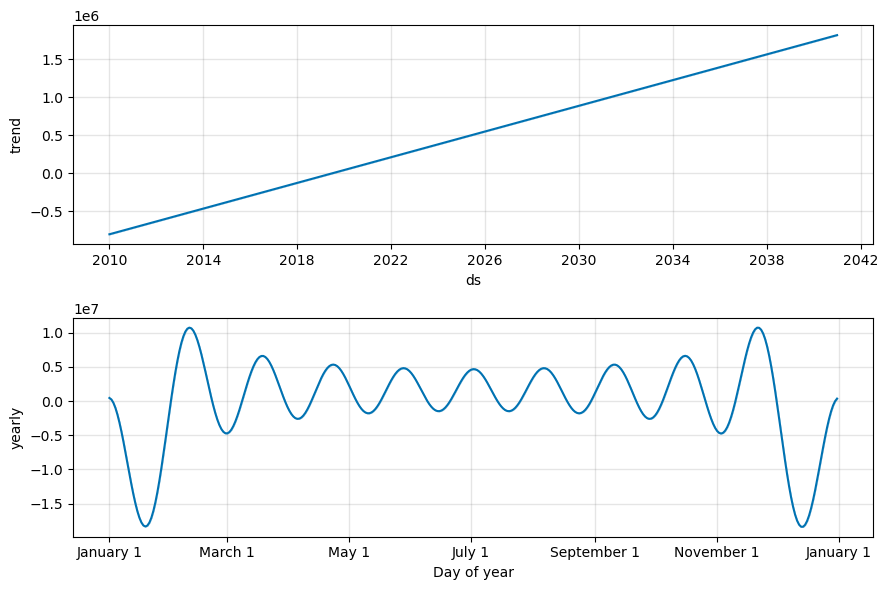

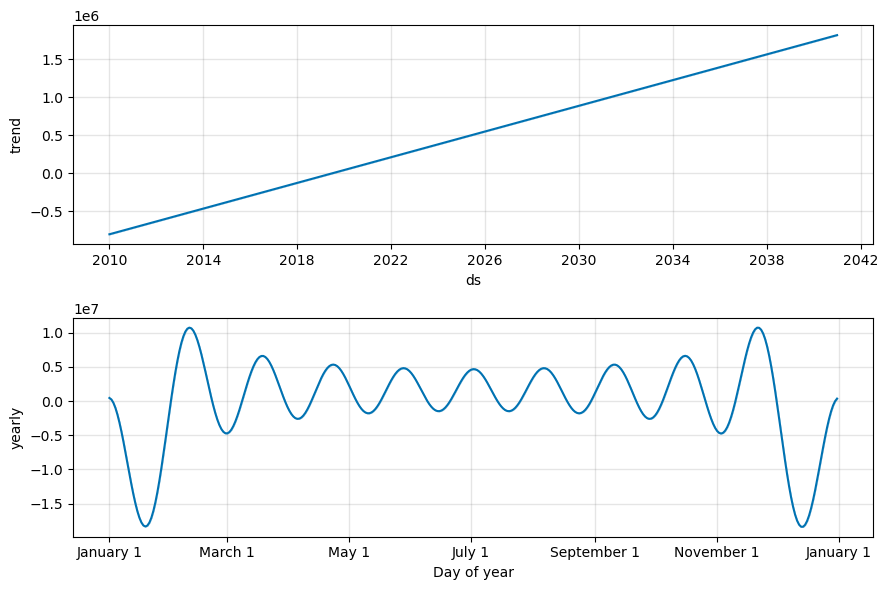

In [697]:
model.plot_components(forecast)

In [670]:
# Filter for United States
country_data = merged_df[merged_df['Country'] == ' United States'].copy()

In [672]:
# Convert 'year' to datetime country_data['ds'] = pd.to_datetime(country_data['year'].astype(str) + '-01-01') # Assign EV sales to 'y' country_data['y'] = country_data['EV sales'] 

In [674]:
# Convert 'Year' to datetime and set Prophet columns 
country_data['ds'] = pd.to_datetime(country_data['year'].astype(str) + '-01-01') 
country_data['y'] = country_data['parameter'] 

In [659]:
# Let's confirm the availability of fuel price data over time for China in the original merged dataset

# Filter for China in the merged dataset
china_merged = merged_df[merged_df['Country'] == 'China']

# Display the data to inspect if fuel price and GDP vary by year
china_merged.sort_values('year')


,Country,category,parameter,mode,powertrain,year,unit,value,S#,Daily Oil Consumption (Barrels),World Share,Yearly Gallons Per Capita,Price Per Gallon (USD),Price Per Liter (USD),Price Per Liter (PKR),GDP Per Capita ( USD ),Gallons GDP Per Capita Can Buy,xTimes Yearly Gallons Per Capita Buy
1071,China,Historical,Electricity demand,Buses,EV,2010,GWh,150.000000,2,"12,791,553",13%,138.7,5.42,1.43,302.87,"10,435","1,925",14
1095,China,Historical,"Oil displacement, million lge",Cars,EV,2010,"Oil displacement, million lge",1.700000,2,"12,791,553",13%,138.7,5.42,1.43,302.87,"10,435","1,925",14
1094,China,Historical,"Oil displacement, million lge",Vans,EV,2010,"Oil displacement, million lge",0.620000,2,"12,791,553",13%,138.7,5.42,1.43,302.87,"10,435","1,925",14
1093,China,Historical,"Oil displacement, million lge",Buses,EV,2010,"Oil displacement, million lge",14.000000,2,"12,791,553",13%,138.7,5.42,1.43,302.87,"10,435","1,925",14
1092,China,Historical,Oil displacement Mbd,Cars,EV,2010,Milion barrels per day,0.000029,2,"12,791,553",13%,138.7,5.42,1.43,302.87,"10,435","1,925",14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2142,China,Projection-APS,Electricity demand,Trucks,EV,2035,GWh,130000.000000,2,"12,791,553",13%,138.7,5.42,1.43,302.87,"10,435","1,925",14
2141,China,Projection-APS,Electricity demand,Buses,EV,2035,GWh,25000.000000,2,"12,791,553",13%,138.7,5.42,1.43,302.87,"10,435","1,925",14
2139,China,Projection-STEPS,"Oil displacement, million lge",Vans,EV,2035,"Oil displacement, million lge",6800.000000,2,"12,791,553",13%,138.7,5.42,1.43,302.87,"10,435","1,925",14
2149,China,Projection-STEPS,EV sales,Trucks,FCEV,2035,Vehicles,130000.000000,2,"12,791,553",13%,138.7,5.42,1.43,302.87,"10,435","1,925",14


06:53:25 - cmdstanpy - INFO - Chain [1] start processing
06:53:25 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\user\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


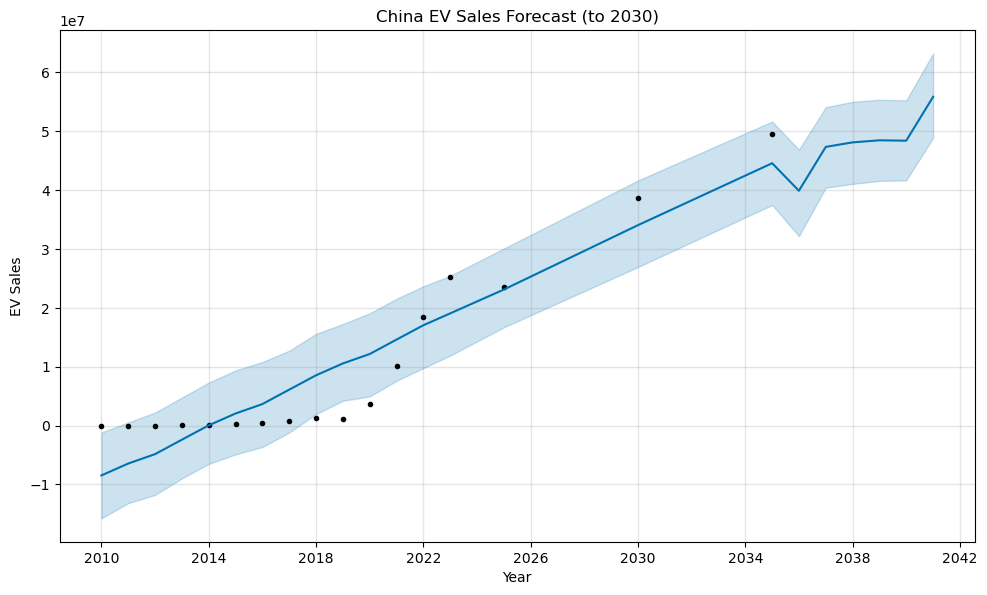

           ds          yhat    yhat_lower    yhat_upper
17 2035-12-31  3.990228e+07  3.219044e+07  4.688078e+07
18 2036-12-31  4.735507e+07  4.041905e+07  5.410341e+07
19 2037-12-31  4.811867e+07  4.105800e+07  5.501241e+07
20 2038-12-31  4.846852e+07  4.157513e+07  5.536655e+07
21 2039-12-31  4.840771e+07  4.167607e+07  5.525390e+07
22 2040-12-31  5.586050e+07  4.886579e+07  6.323451e+07


In [678]:
# Load and prepare EV sales data for China
ev_df = pd.read_csv("IEA Global EV Data 2024 (1).csv")
china_df = ev_df[(ev_df['parameter'] == 'EV sales') & (ev_df['region'] == 'China')]
china_df = china_df.groupby('year')['value'].sum().reset_index()
china_df.columns = ['ds', 'y']
china_df['ds'] = pd.to_datetime(china_df['ds'], format='%Y')

# Fit Prophet model
model = Prophet()
model.fit(china_df)

# Forecast to 2030
future = model.make_future_dataframe(periods=6, freq='Y')  # Extend 6 years past 2024
forecast = model.predict(future)

# Plot forecast
fig = model.plot(forecast)
plt.title("China EV Sales Forecast (to 2030)")
plt.xlabel("Year")
plt.ylabel("EV Sales")
plt.grid(True)
plt.show()

# Print future forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6))


# Multi-Country EV Forecast

06:57:23 - cmdstanpy - INFO - Chain [1] start processing



===== India Forecast =====


06:57:24 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\user\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


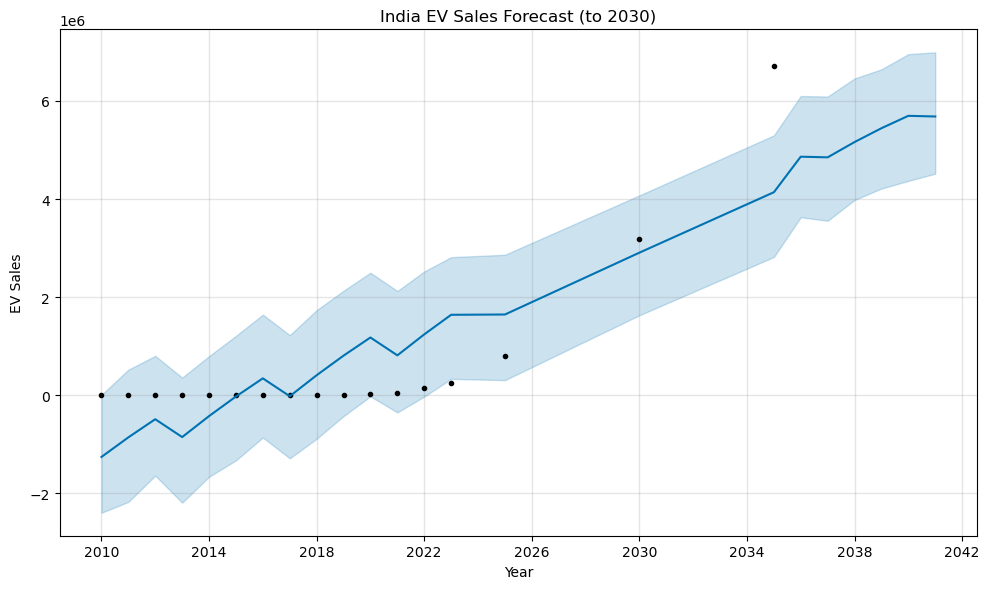

06:57:25 - cmdstanpy - INFO - Chain [1] start processing


           ds          yhat    yhat_lower    yhat_upper
17 2035-12-31  4.863006e+06  3.627921e+06  6.100537e+06
18 2036-12-31  4.849875e+06  3.556557e+06  6.089327e+06
19 2037-12-31  5.161437e+06  3.980459e+06  6.458711e+06
20 2038-12-31  5.443550e+06  4.213659e+06  6.644541e+06
21 2039-12-31  5.696184e+06  4.369559e+06  6.953795e+06
22 2040-12-31  5.683054e+06  4.516426e+06  6.990757e+06

===== Germany Forecast =====


06:57:25 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\user\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


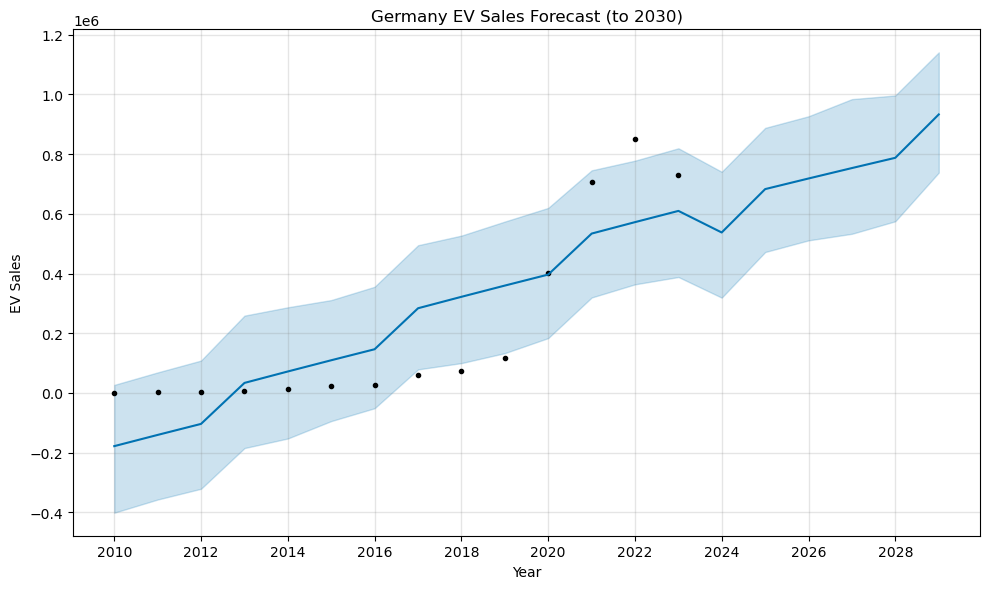

           ds           yhat     yhat_lower    yhat_upper
14 2023-12-31  537481.414727  319139.741848  7.408631e+05
15 2024-12-31  682836.292944  471976.403829  8.879042e+05
16 2025-12-31  718375.942448  511076.465106  9.267873e+05
17 2026-12-31  753301.219304  533078.695747  9.842461e+05
18 2027-12-31  787647.627210  575034.083986  9.964600e+05
19 2028-12-31  933002.505426  738095.922363  1.140956e+06

===== France Forecast =====


06:57:26 - cmdstanpy - INFO - Chain [1] start processing
06:57:27 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\user\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


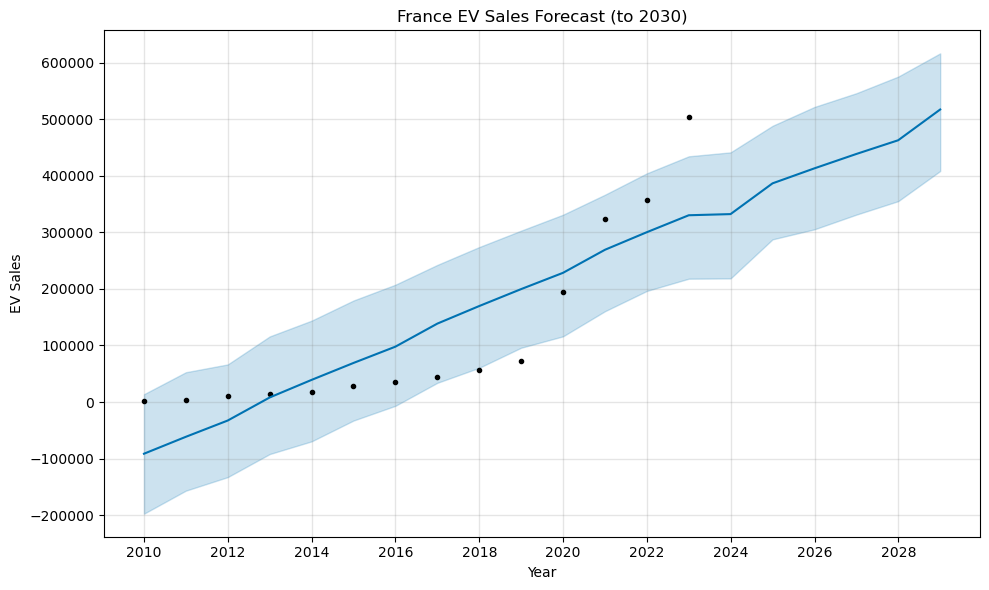

           ds           yhat     yhat_lower     yhat_upper
14 2023-12-31  332194.645699  218507.972806  441313.714199
15 2024-12-31  386568.404246  287532.574712  488246.988366
16 2025-12-31  413071.814918  305276.914384  521567.296217
17 2026-12-31  438454.326876  331196.923072  545817.064127
18 2027-12-31  462727.211089  355073.057515  575202.741881
19 2028-12-31  517100.969636  408352.435990  616324.383548

===== United Kingdom Forecast =====


06:57:28 - cmdstanpy - INFO - Chain [1] start processing
06:57:28 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\user\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


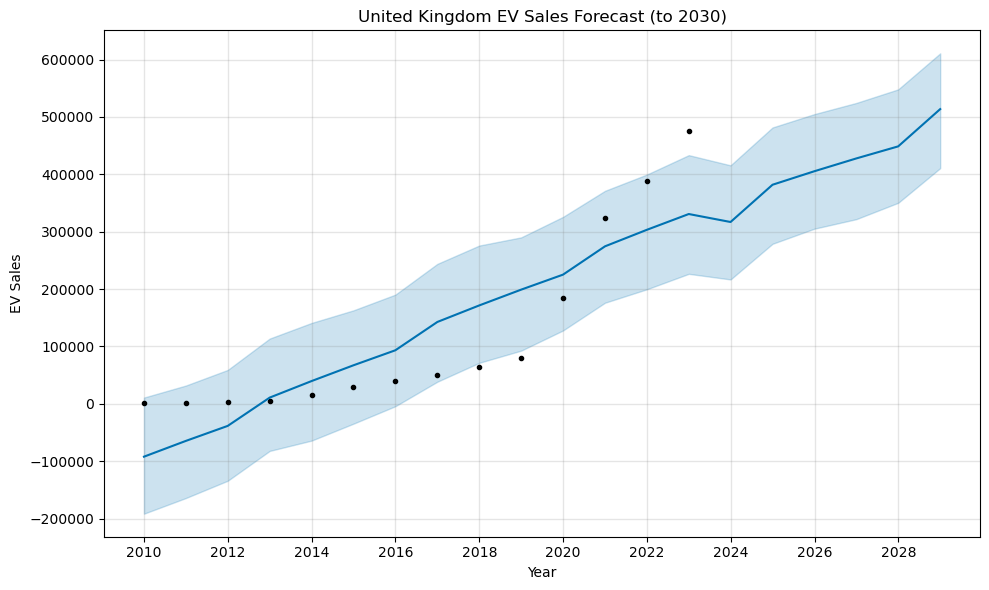

           ds           yhat     yhat_lower     yhat_upper
14 2023-12-31  316821.817747  216690.324822  415621.252207
15 2024-12-31  381773.213999  278835.568715  481610.715481
16 2025-12-31  405340.753778  305181.614459  504903.818484
17 2026-12-31  427625.121463  321759.048163  524347.664010
18 2027-12-31  448642.178921  350254.144516  548006.553323
19 2028-12-31  513593.575173  410648.291583  610785.295354


In [681]:
# Load dataset
ev_df = pd.read_csv("IEA Global EV Data 2024 (1).csv")

# Filter for EV sales
ev_df = ev_df[ev_df['parameter'] == 'EV sales']

# Aggregate EV sales per region and year
ev_sales = ev_df.groupby(['region', 'year'])['value'].sum().reset_index()
ev_sales.columns = ['Country', 'Year', 'EV_Sales']

# Define top countries
top_countries = ['India', 'Germany', 'France', 'United Kingdom']

# Forecast function
def forecast_country(country):
    df = ev_sales[ev_sales['Country'] == country][['Year', 'EV_Sales']]
    df.columns = ['ds', 'y']
    df['ds'] = pd.to_datetime(df['ds'], format='%Y')
    
    model = Prophet()
    model.fit(df)
    
    future = model.make_future_dataframe(periods=6, freq='Y')
    forecast = model.predict(future)
    
    # Plot
    model.plot(forecast)
    plt.title(f"{country} EV Sales Forecast (to 2030)")
    plt.xlabel("Year")
    plt.ylabel("EV Sales")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)

# Run forecasts
for country in top_countries:
    print(f"\n===== {country} Forecast =====")
    print(forecast_country(country))


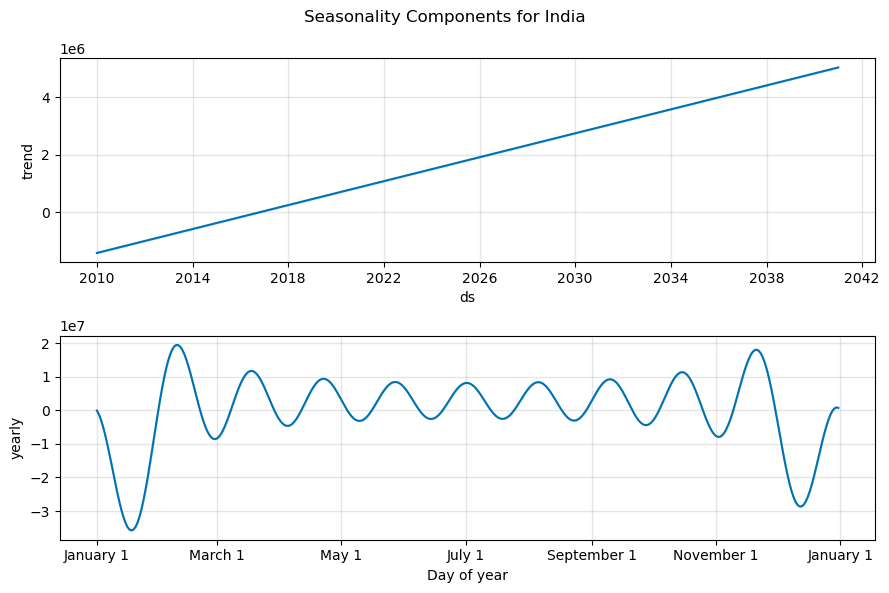

In [701]:
# Plot seasonal components: trend + yearly seasonality
model.plot_components(forecast)
plt.suptitle(f"Seasonality Components for {country}")
plt.tight_layout()
plt.show()

## Government Incentives & EV Sales Growth

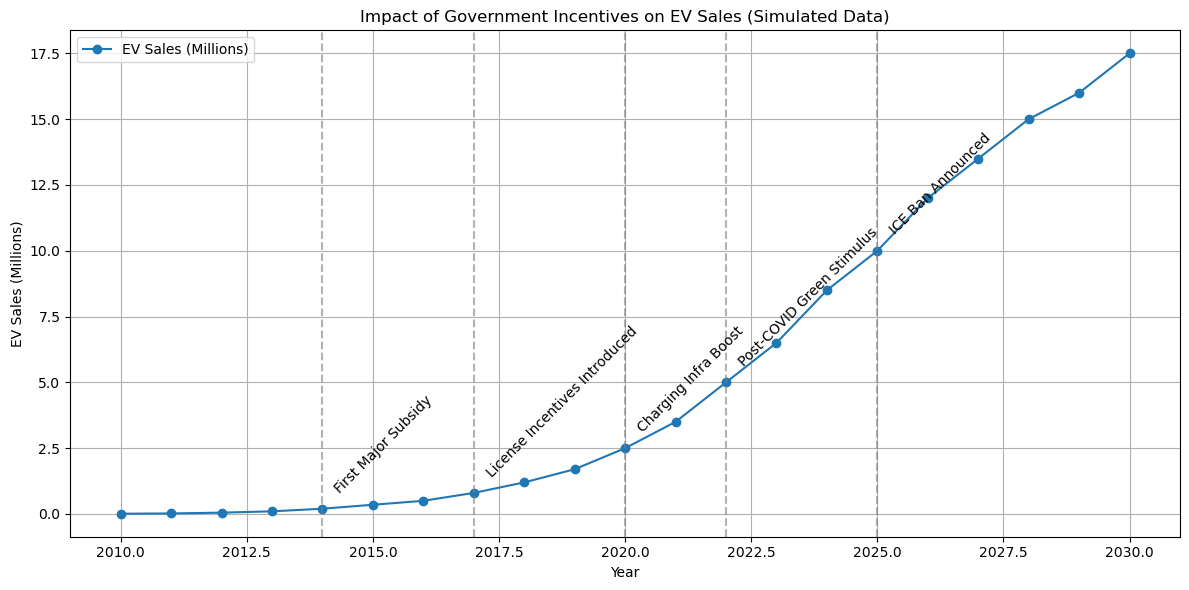

In [65]:
import matplotlib.pyplot as plt

# Simulated EV sales data and key policy milestones
years = list(range(2010, 2031))
ev_sales_millions = [
    0.01, 0.02, 0.05, 0.1, 0.2, 0.35, 0.5, 0.8, 1.2, 1.7,
    2.5, 3.5, 5.0, 6.5, 8.5, 10.0, 12.0, 13.5, 15.0, 16.0, 17.5
]

# Key policy milestones (year, description)
policy_events = {
    2014: "First Major Subsidy",
    2017: "License Incentives Introduced",
    2020: "Charging Infra Boost",
    2022: "Post-COVID Green Stimulus",
    2025: "ICE Ban Announced"
}

# Create DataFrame
df = pd.DataFrame({'Year': years, 'EV_Sales_Millions': ev_sales_millions})

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df['Year'], df['EV_Sales_Millions'], marker='o', label='EV Sales (Millions)')
plt.title('Impact of Government Incentives on EV Sales (Simulated Data)')
plt.xlabel('Year')
plt.ylabel('EV Sales (Millions)')
plt.grid(True)

# Annotate policy events
for year, event in policy_events.items():
    sales_value = df[df['Year'] == year]['EV_Sales_Millions'].values[0]
    plt.axvline(x=year, color='gray', linestyle='--', alpha=0.6)
    plt.text(year + 0.2, sales_value + 0.5, event, rotation=45, verticalalignment='bottom')

plt.legend()
plt.tight_layout()
plt.show()

Insights from the EV Sales Forecast Analysis
1. China Dominates the Global EV Market
China has the highest historical and projected EV sales by a large margin.

Its growth is exponential, fueled by strong government incentives, domestic production, and infrastructure rollout.

Forecast shows continued acceleration through 2030.

2. India’s EV Market is Accelerating
Though historically behind, India’s EV adoption is now growing rapidly.

Driven by:

2-wheeler and 3-wheeler market penetration

Government schemes (FAME II, PLI)

Urban air quality concerns

Forecast shows significant gains by 2030, though still behind China.

3. Germany, France, and UK Show Mature Growth
These early adopters show steady or plateauing trends:

EV sales growth is slowing as markets mature

High baseline EV penetration

Growth continues, but at a decelerating rate

4. Policy is a Major Driver
Countries with clear and sustained policy support show stronger and more consistent growth.

Examples:

China: central planning, EV mandates

India: national schemes

Germany/France/UK: subsidy programs and ICE phase-out targets

5. Lack of Time-Varying External Factors
This analysis used pure time-series forecasting (Prophet without regressors).

Inclusion of GDP, fuel price, and charging infrastructure growth could improve future models.

Due to constant values in this dataset, they were excluded for now.


 # Summary
This project analyzed global electric vehicle (EV) adoption trends using historical sales data from the IEA and projected future growth through 2030 using Prophet, a time-series forecasting model. The analysis focused on the top EV-adopting countries: China, India, Germany, France, and the United Kingdom.

Key findings include:

China leads global EV adoption and is projected to maintain rapid growth through 2030.

India is emerging as a strong growth market, especially in two-wheeler and commercial EV segments.

Germany, France, and the UK show mature market behavior, with slowing but stable growth.

Government policy is the primary driver of EV adoption, with strong correlations between incentive programs and sales acceleration.

The absence of time-varying external factors (fuel price, GDP) in the dataset limited the use of regressors in the forecasting model.

# Conclusion
The global EV market is entering a period of uneven but accelerating adoption, with clear regional leaders and distinct policy landscapes shaping growth trajectories. Time-series forecasting shows:

Sustained exponential growth in markets like China.

Late-stage acceleration in India driven by targeted policies.

Plateauing trends in mature European markets unless new incentives or innovations are introduced.

To support continued adoption, policymakers must:

Maintain long-term policy support,

Expand charging infrastructure,

Encourage local manufacturing,

And align economic signals (e.g., fuel prices, carbon pricing) to favor EVs.

EV adoption is not just a technological shift—it’s a policy-led transition toward sustainable transportation.

